# Example usage

Here we will demonstrat how to use `pyredraw` to construct replicate times series by performing the moving block bootstrap. 

An application of the moving block bootstrap function from `pyredraw` will be shown. The application will be to a seasonal time series and will follow the general approach by Bergmeir et al.$^1$ 

Starting with a given seasonal time series in the upper left of the diagram, we will perform a Box-Cox transform, followed by a STL decomposition. With the residuals resulting from the STL decomposition, replicate residuals will be formed and which are highlighted in a yellow box in the diagram. These replicate residuals are created by using the `moving_block_bootstrap()` function from `pyredraw`. 

![BERGMEIR_1](example_usage_following_bergmeir_1a.png)

With each of the bootsrapped residual replicates, we will then add back the trend and seasonality time series components found from the STL decomposition, and perform an inverse Box-Cox transform to obtain a bootstrapped replicate of the original time series.

![BERGMEIR_2](example_usage_following_bergmeir_2.png)

## Import packages, time series data, and create a Numpy array

In [1]:
from pyredraw.pyredraw import count_words
from pyredraw.plotting import plot_words

import pandas as pd
import numpy as np
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt
from pyredraw.ts import moving_block_bootstrap
from pyredraw.plotting import plot_replicates

In [2]:
# read in time series data
df = pd.read_csv("iceland_montly_retail_debit_card_expenditures.csv", 
                  index_col='date',
                  parse_dates=True
                 )
df.head()

,monthly_expenditure
date,
2000-01-01,7.204
2000-02-01,7.335
2000-03-01,7.812
2000-04-01,7.413
2000-05-01,9.136


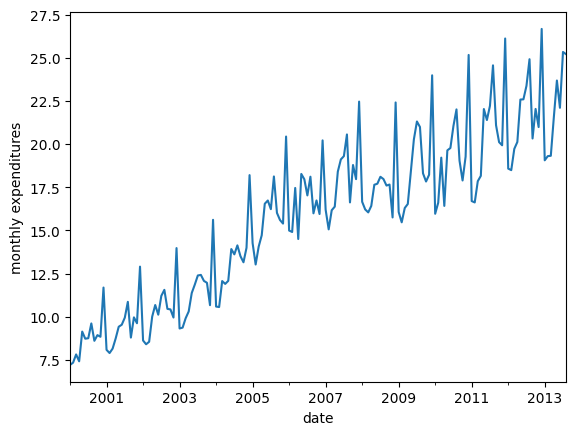

In [3]:
# create pandas series, add frequency of time index (Monthly, Starting)
sr = df.squeeze()
sr = sr.asfreq('MS')

# plot time series - time series shows clear seasonality
ax = sr.plot()
ax.set_ylabel("monthly expenditures")
plt.show()

In [4]:
sr.values

array([ 7.204,  7.335,  7.812,  7.413,  9.136,  8.725,  8.751,  9.609,
        8.601,  8.93 ,  8.835, 11.688,  8.078,  7.892,  8.151,  8.738,
        9.416,  9.533,  9.943, 10.859,  8.789,  9.96 ,  9.619, 12.9  ,
        8.62 ,  8.401,  8.546, 10.004, 10.675, 10.115, 11.206, 11.555,
       10.453, 10.421,  9.95 , 13.975,  9.315,  9.366,  9.91 , 10.302,
       11.371, 11.857, 12.387, 12.421, 12.073, 11.963, 10.666, 15.613,
       10.586, 10.558, 12.064, 11.899, 12.077, 13.918, 13.611, 14.132,
       13.509, 13.152, 13.993, 18.203, 14.262, 13.024, 14.062, 14.718,
       16.544, 16.732, 16.23 , 18.126, 16.016, 15.601, 15.394, 20.439,
       14.991, 14.908, 17.459, 14.501, 18.271, 17.963, 17.026, 18.111,
       15.989, 16.735, 15.949, 20.216, 16.198, 15.06 , 16.168, 16.376,
       18.403, 19.113, 19.303, 20.56 , 16.621, 18.788, 17.97 , 22.464,
       16.658, 16.214, 16.043, 16.418, 17.644, 17.705, 18.107, 17.975,
       17.598, 17.658, 15.75 , 22.414, 16.065, 15.467, 16.297, 16.53 ,
      

## Perform Box-Cox transform and STL decomposition on transformed result

In [5]:
# Do box-cox transform
boxcox_array, lambda_val = boxcox(sr.values)

# make series from array resulting from box-cox 
boxcox_series = pd.Series(
    boxcox_array, index=pd.date_range("1-1-2000", periods=len(boxcox_array), freq="MS")
    , name="monthly_expenditures"
)

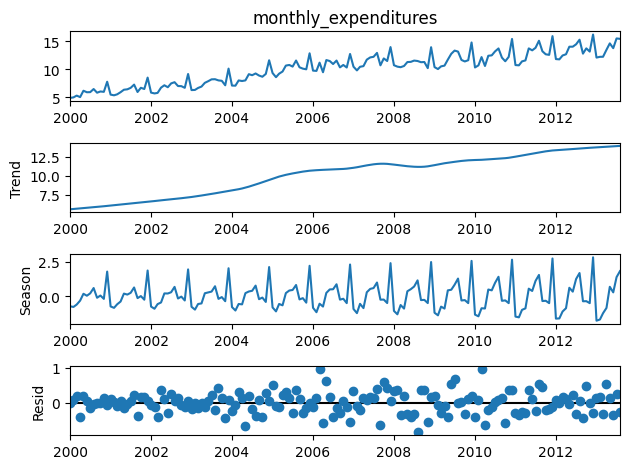

In [6]:
# do STL decomp (note seasonal = period+1, seasonal must be odd)
period=12
stl = STL(boxcox_series, seasonal=(period+1))
stl_result = stl.fit()

# Plot STL decomposition results
fig = stl_result.plot()

## Apply `moving_block_bootstrap` from the `pyredraw` package to STL residuals

In [7]:
# define parameters for moving block bootstrap
block_length = int(2 * period)
number_replicates = 10

# do moving block bootstrap of STL residuals 
residual_replicates = moving_block_bootstrap(stl_result.resid, 
                                             block_length, 
                                             number_replicates, 
                                             seed = 1027)

In [8]:
residual_replicates.shape

(10, 164)

In [9]:
# make residual array into pandas dataframe 
# adding back seasonal and trend from STL, do inverse Box-Cox
df_replicates = pd.DataFrame(columns=["monthly_expenditures", "replicate"])
number_replicates, _ = residual_replicates.shape
number_replicates_array = np.arange(0, number_replicates)

for replicate in number_replicates_array:
    # make residual in a pandas series with correct datetime index
    sr_temp = pd.Series(residual_replicates[replicate,], 
                        index=pd.date_range("1-1-2000", 
                                            periods=len(residual_replicates[replicate,]), 
                                            freq="MS"),
                         name="monthly_expenditures"
                        )
    # add seasonal and trend components from STL to residual replicate
    sr_total_temp = sr_temp + stl_result.seasonal + stl_result.trend
    sr_total_temp =sr_total_temp.rename("monthly_expenditures")
    
    # do inverse Box-Cox (using exponent lambda that was found in the initial Box Cox)  
    sr_inv_boxcox = inv_boxcox(sr_total_temp, lambda_val)

    # make pandas series into temp dataframe and add replicate field
    df_temp = pd.DataFrame(sr_inv_boxcox)
    df_temp["replicate"] = replicate
    
    # concatenate 
    df_replicates = pd.concat([df_replicates, df_temp])

In [10]:
df_replicates.info()
df_replicates.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1640 entries, 2000-01-01 to 2013-08-01
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   monthly_expenditures  1640 non-null   float64
 1   replicate             1640 non-null   object 
dtypes: float64(1), object(1)
memory usage: 38.4+ KB


,monthly_expenditures,replicate
2000-01-01,6.639942,0
2000-02-01,6.726259,0
2000-03-01,6.302820,0
2000-04-01,8.579374,0
2000-05-01,9.398532,0


## Plot replicates and original time series on same axis to compare

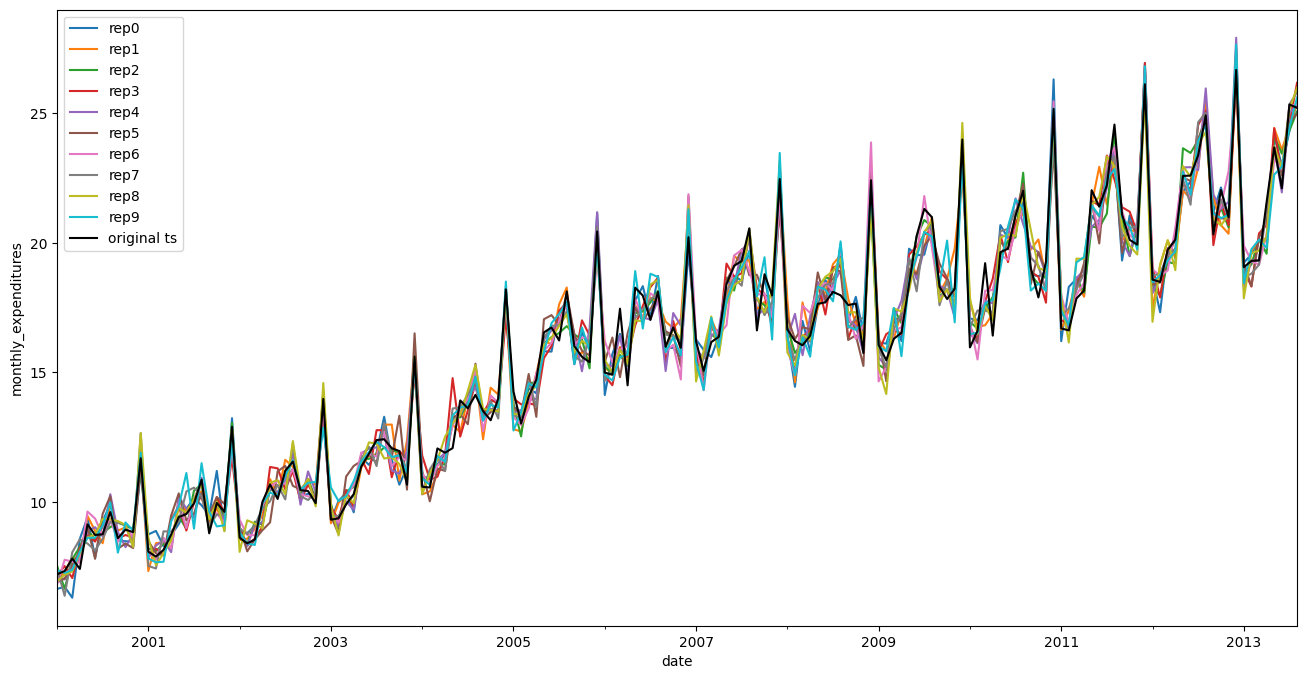

In [12]:
# Plot replicates and original time series
plot_replicates(sr, df_replicates, "monthly_expenditures")

Citation:
1. C. Bergmeir, R. J. Hyndman, and J. M. Ben´ıtez, “Bagging exponential smoothing
methods using STL decomposition and Box–Cox transformation,” International journal
of forecasting, vol. 32, no. 2, pp. 303–312, 2016.    